In [21]:
%cd /home/ron/PycharmProjects/gait_project

/home/ron/PycharmProjects/gait_project


In [22]:
from gait_analysis import Datasets3
from gait_analysis.Datasets3 import TumGAID_Dataset,  OfPatchesConcat, DsetWrapper
#from gait_analysis.Datasets3 import TumGAID_Dataset,  OfPatchesConcat
from gait_analysis import settings as S
import torch
import torchvision
import torchvision.transforms as transforms
import sys
import os
import numpy as np
sys.path.insert(0, '..')
import cv2


tumgaid_default_args = {
    'load_pose': True,
    'load_pose_options': {
        'D': 2,
        'body_keypoints_include_list': ['LAnkle',
                                        'RAnkle',
                                        'LKnee',
                                        'RKnee',
                                        'RHip',
                                        'LHip']
    },
    'load_flow': True,
    'load_flow_options': {
        'method': 'dense',
        'load_patches': True,
        'load_patch_options': {
            'patch_size': 20
        }
    },
    'load_scene': True,
    'load_scene_options': {
        'grayscale': False,
        'load_tracked': False
    },
    'include_scenes': ['b01', 'b02', 'n01', 'n02', 's01', 's02'],
    #'include_scenes': ['b01', 'b02'],
    'frames_to_concat': 5,
}

dset = TumGAID_Dataset(S.tumgaid_root,
                       S.tumgaid_preprocessing_root,
                       S.tumgaid_annotations_root,
                       tumgaid_default_args)

transformations = transforms.Compose([transforms.ToTensor()])



In [24]:
train_dset = TumGAID_Dataset(S.tumgaid_root,
                          S.tumgaid_preprocessing_root,
                          S.tumgaid_annotations_root_train,
                          #transformations,
                          tumgaid_default_args)

#output, annotations = train_dset[0]

test_dset = TumGAID_Dataset(S.tumgaid_root,
                          S.tumgaid_preprocessing_root,
                          S.tumgaid_annotations_root_test,
                          #transformations,
                          tumgaid_default_args)

#dset = {x: TumGAID_Dataset(S.tumgaid_root,
#                          S.tumgaid_preprocessing_root,
#                          os.path.join(S.tumgaid_annotations_root, x),
#                          #transformations,
#                          tumgaid_default_args)
#                  for x in ['train', 'val']}

dset_wrap = DsetWrapper(train_dset)

dset_ready=OfPatchesConcat(dset_wrap, tumgaid_default_args)

/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [9]:
print(type(dset_ready))
print(os.getcwd())

<class 'gait_analysis.Datasets3.OfPatchesConcat'>
/home/ron/PycharmProjects/gait_project


In [138]:
import pickle

#with open('gait_data_train.pkl', 'wb') as output:
#    pickle.dump(dset_ready, output, pickle.HIGHEST_PROTOCOL)
    
#with open('gait_datatest.pkl', 'wb') as output:
#    pickle.dump(dset_ready, output, pickle.HIGHEST_PROTOCOL)

    
#del dset_ready

with open('gait_data_train.pkl', 'rb') as input:
    dset_ready = pickle.load(input)

with open('gait_data_test.pkl', 'rb') as input:
    dset_ready_test = pickle.load(input)

    


In [25]:
print(dset_ready)

In [93]:
import torch
import torchvision.models as models
import  torch.nn.functional  as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchviz import make_dot
import torch.nn as nn
import timeit
import scipy.io
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
from matplotlib import pyplot as plt

In [27]:
dset_wrap_test = DsetWrapper(test_dset)

dset_ready_test=OfPatchesConcat(dset_wrap_test, tumgaid_default_args)

/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [28]:
import pickle

with open('gait_data_train.pkl', 'wb') as output:
    pickle.dump(dset_ready, output, pickle.HIGHEST_PROTOCOL)
    
with open('gait_data_test.pkl', 'wb') as output:
    pickle.dump(dset_ready_test, output, pickle.HIGHEST_PROTOCOL)

In [139]:
class SampleData(Dataset):
    
    def __init__(self, idx, base_dataset):
        self.idx = idx
        self.base_dataset = base_dataset
    
    def __len__(self):
        return self.idx
    
    def __getitem__(self, i):
        
        flow, poses, annotations = self.base_dataset[i]
        return flow, poses, annotations

# to delete, only for overfitting
dset_ready=SampleData(40, dset_ready)
#dset_ready = dset_ready[0:40]
dset_ready_test=SampleData(8, dset_ready_test)

In [140]:
print(len(dset_ready))


40


In [141]:
#test_mask = np.zeros(len(dset_ready))
#test_mask[0:40] = 1
#test_mask = torch.from_numpy(test_mask)


test_Sampler = MySampler(test_mask)

dataloader={}

dataloader['train'] = DataLoader(dset_ready, batch_size=4, shuffle=True)

dataloader['val'] = DataLoader(dset_ready_test, batch_size=4,
                        shuffle=True)



#dataloader = {x: DataLoader(dset[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

In [183]:
for i, data in enumerate(dataloader['train']):
    
    flow,pos, ants = data
    print (ants)

tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  0.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]], dtype=torch.float64)
tensor([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  1.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 0.,  0.],
        [ 1.,  0.],
        [ 0.,  0.]], dtype=torch.float64)
tensor([[ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.]], d

In [142]:
print(len(dset_ready))

for flow, poses, ants in dataloader['train']:
    print(ants)

40
tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  0.]], dtype=torch.float64)
tensor([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 0.,  0.],
        [ 0.,  1.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  0.]]

In [143]:
dataset_sizes = {}
dataset_sizes['train'] = len(dset_ready)
dataset_sizes['val'] = len(dset_ready_test)

print(dataset_sizes['val'])

8


In [8]:
flow, poses, ants = next(iter(dataloader['train']))
#flow, poses, ants = (flow.cuda(), poses.cuda(), ants.cuda())
#print(poses)
ants = ants.numpy()
print(type(ants))
test = print(torch.from_numpy(ants))
print(ants)

<class 'numpy.ndarray'>
tensor([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]], dtype=torch.float64)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [114]:
def convert_ants_to_classes(ants): 
    return ants[0]*2 + ants[1] 

def to_categorical(y, num_classes=3):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [144]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [168]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    cntr = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for flow, poses, ants in dataloader[phase]:
                ### reshape poses to flat vector
                pos_shape = poses.shape
                poses = np.reshape(poses,(-1,pos_shape[1]*pos_shape[2]))
                ### todo ants to clas nrs 
                #print(ants)
                labels = np.zeros(len(ants),)
                for i in range(len(ants)):
                    labels[i] = np.int(convert_ants_to_classes(ants[i,:]))
                    #print(i)
                    #print(labels[i])
                    #labels[i,:] = to_categorical(label)
                    #print(label)
                    
                
                labels = torch.from_numpy(labels)
                #print(labels)
                flow, poses, labels = (flow.to(device), poses.to(device), labels.to(device))

                #print(flow.type())
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(flow,poses)
                    _, preds = torch.max(outputs, 1)
                    labels = labels.long()
                    #print (labels)
                    #print (preds)
                    loss = criterion(outputs, labels)

                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #cntr += 1
                        #print(cntr)
                        #print(loss.type())
                        #print(labels)
                        #print(outputs)
                        #print(loss)
                        #print('------------------')
                        torch.backends.cudnn.benchmark=True
                        loss.backward()
                        optimizer.step()
                        scheduler.step(loss)

                # statistics
                running_loss += loss.item() * flow.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print(running_corrects)
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [169]:
def Downsample (inplanes, outplanes, stride=2):
    downsample = nn.Sequential(
                nn.Conv2d(inplanes, outplanes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outplanes),
    )
    return downsample

class OwnResNetBlock(nn.Module):

    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(OwnResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = downsample


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class OwnResNetLikeModel(nn.Module):  

    def __init__(self, square_size, no_poses, in_planes, num_classes=3):  
        super(OwnResNetLikeModel, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.layer1 = OwnResNetBlock(64,64,stride=2,downsample=Downsample(64,64))
        self.layer2 = OwnResNetBlock(64,128,stride=2,downsample=Downsample(64,128))
        
        last_filter_size = 128
        downsampling_factor =4
        self.no_poses = np.int(no_poses)
        self.input_size_fc = np.int(((square_size/downsampling_factor)**2) * last_filter_size + no_poses)        
        self.fc1 = nn.Linear(self.input_size_fc, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512,3)
        
        self.Dropout = nn.Dropout(p=0.5)

    def forward(self, x, keypoints):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        
        #print(x.shape)
        x = x.view(-1, self.input_size_fc - self.no_poses)
        #print(x.shape)
        #print(x.type())
        keypoints = keypoints.float()
        #print(keypoints.type())
        x = torch.cat((x,keypoints),dim=1)

        x = self.fc1(x)
        x = self.Dropout(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.Dropout(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        
        return x


In [175]:
from torch import optim

patch_size = tumgaid_default_args['load_flow_options']['load_patch_options']['patch_size']
no_poses_per_frame = len(tumgaid_default_args['load_pose_options']['body_keypoints_include_list'])
frames_to_concat = tumgaid_default_args['frames_to_concat']

# flow has 3 dimensions, the keypoints have only 2.
model_ft = OwnResNetLikeModel(2*patch_size,2*no_poses_per_frame*frames_to_concat,3*no_poses_per_frame*frames_to_concat)
model_ft.to(device)



In [177]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=1, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=500)

In [179]:
### test case
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [ ]:
### test case
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader['train'], 0):
        # get the inputs
        flow, pos, ants = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [119]:
import time
import copy
torch.backends.cudnn.benchmark=True

In [176]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 3.7508 Acc: 0.3500
val Loss: 0.8388 Acc: 0.8750

Epoch 1/199
----------
train Loss: 4.8867 Acc: 0.2250
val Loss: 0.8440 Acc: 0.8750

Epoch 2/199
----------
train Loss: 2.5830 Acc: 0.5250
val Loss: 0.8481 Acc: 1.0000

Epoch 3/199
----------
train Loss: 3.3847 Acc: 0.4000
val Loss: 0.8542 Acc: 1.0000

Epoch 4/199
----------
train Loss: 3.1640 Acc: 0.4250
val Loss: 0.8614 Acc: 1.0000

Epoch 5/199
----------
train Loss: 3.4256 Acc: 0.3250
val Loss: 0.8667 Acc: 1.0000

Epoch 6/199
----------
train Loss: 4.2756 Acc: 0.2750
val Loss: 0.8686 Acc: 0.8750

Epoch 7/199
----------
train Loss: 2.6699 Acc: 0.3750
val Loss: 0.8689 Acc: 1.0000

Epoch 8/199
----------
train Loss: 3.9942 Acc: 0.3500
val Loss: 0.8687 Acc: 1.0000

Epoch 9/199
----------
train Loss: 3.4765 Acc: 0.4000
val Loss: 0.8656 Acc: 1.0000

Epoch 10/199
----------
train Loss: 3.7360 Acc: 0.2750
val Loss: 0.8641 Acc: 1.0000

Epoch 11/199
----------
train Loss: 3.8410 Acc: 0.3250
val Loss: 0.8658 Acc

In [7]:
ix_rnd = np.int(np.random.randint(0,len(train_dset),1))
print(ix_rnd)
output, annotations = dset['train'][ix_rnd]
print()


scene_images = output['scene_images'][20]
total_image = output['total_images'][20]
flow_maps = output['flow_maps'][20]


6


/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [9]:
print(type(annotations))

<class 'pandas.core.frame.DataFrame'>


In [8]:
print (type(output))

inputs, annotations = next(iter(dataloader['train']))

<class 'dict'>


/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


TypeError: batch must contain tensors, numbers, dicts or lists; found <class 'dict_values'>

AttributeError: module 'torch' has no attribute 'device'

In [ ]:
print(inputs)

In [8]:
scene_image = scene_images[5]
flow_map = flow_maps[5]

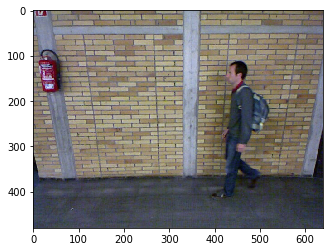

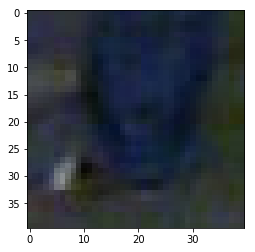

In [9]:
plt.imshow(total_image)
plt.figure()
plt.imshow(scene_image)

In [9]:
def plot_flow(of):
    ofx = of[:,:,0]
    ofy = of[:,:,1]
    ofmagnitude = of[:,:,2]
    size_x, size_y = ofx.shape
    X, Y = np.meshgrid(np.arange(size_y), np.arange(size_x))
    U = ofx.copy()
    V = ofy.copy()
    
    spacing = 10
    X,Y,U,V = map( lambda x: x[::spacing, ::spacing], (X,Y,U,V))
    
    fig, ax = plt.subplots(frameon=False)
    ax.imshow(ofmagnitude)
    ax.set_axis_off()
    ax.quiver(X,Y,U,V, units='xy', scale=0.5)
    return fig, ax

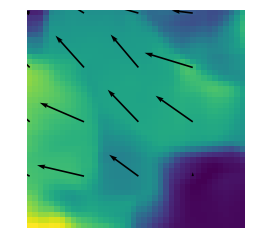

In [10]:
fig, ax = plot_flow(flow_map)

In [58]:
import torchvision.models as models
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import os

In [66]:
vgg16_bn = models.vgg16_bn(pretrained=True)
pretrained_resnet18 = models.resnet18(pretrained=True)

In [62]:
# smaller model bcs of smaller dataset, conv only
#model_cut = nn.Sequential(*list(pretrained_model.features.children())[1:-10]) 


Sequential(
  (0): Conv2d(60, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)


In [70]:
class own_vgg(torch.nn.Module):
    def __init__(self):
        super(own_vgg, self).__init__()
        first_conv = nn.Conv2d(60, 64, 3, 1, 1)
        pretrained_model = models.vgg16_bn(pretrained=True)
        features = list(pretrained_model.features)[1:-10] 
        features = nn.ModuleList(features).eval() 
        self.features = nn.Sequential(first_conv, features)
         
    def forward(self, x):
        x = self.features(x)
        return x
        

In [71]:
own_vgg_model = own_vgg()
print(own_vgg_model)
#mymodel = own_vgg()
print('----------------------')
print(vgg16_bn)

own_vgg(
  (features): Sequential(
    (0): Conv2d(60, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (8): ReLU(inplace)
      (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14)

In [111]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


90
